In [56]:
import pandas as pd
import os
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.dummy import DummyClassifier
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import re
from collections import Counter
import pickle
from numpy.random import seed
nltk.download('stopwords')
seed(3)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nelsonlim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# change
BINANCE_DIR = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/binance/processed/day_discrete"
TWITTER_DIR = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/twitter"
REDDIT_DIR = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/reddit"

TWITTER_FILE = "twitter.csv"
REDDIT_FILE  = "reddit.csv"

FIGURE_DIR = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/notebook/img"

# SAVED MODELS & VARIABLES
COUNT_VECTORISER_FILE = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/count_vectoriser.pkl" # x
COUNT_VECTORISER_VAR_FILE = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/count_vectoriser_var.pkl" # vectorizer data
SVM_FILE = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/SVM_model.pkl"

# dont change
BINANCE_EXTENSION = "csv"

START_DATE = "2018-01-01"
END_DATE = "2021-10-31"

In [3]:
def concatenate_content_values(content_list):
	return content_list.str.cat(sep=" ")

# Dataset

### Binance

In [4]:
# load binance data
df_binance_list = []
for filename in sorted(os.listdir(BINANCE_DIR)):
    if filename.endswith(BINANCE_EXTENSION):
        df_binance_list.append(pd.read_csv( os.path.join(BINANCE_DIR,filename)))
df_binance = pd.concat(df_binance_list,ignore_index=True)

# convert time to date obj
df_binance['time'] = pd.to_datetime(df_binance['time'])

# change index to time
df_binance = df_binance.set_index('time')

# filter date range
df_binance = df_binance.loc[START_DATE:END_DATE]

In [5]:
price_mean = df_binance['price_mean']
binance_time = df_binance.index.strftime("%m/%d/%y").values
plot_x = range(len(binance_time))

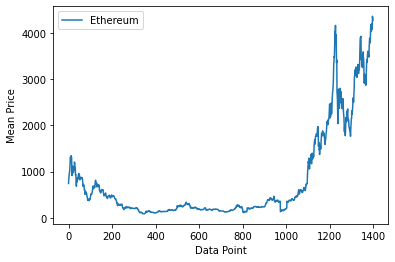

In [6]:
plt.plot(plot_x, price_mean)   
plt.legend(['Ethereum'])
plt.xlabel("Data Point")
plt.ylabel("Mean Price")
plt.savefig(os.path.join(FIGURE_DIR,"binance_mean_price"))
plt.show()    

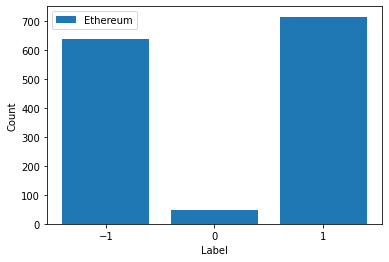

In [7]:
labels = Counter(df_binance['label'].values)
labels_keys = list(labels.keys())
labels_values = list(labels.values())

plt.bar(labels_keys, labels_values)
plt.xticks(labels_keys)
plt.legend(['Ethereum'])
plt.xlabel("Label")
plt.ylabel("Count")
plt.savefig(os.path.join(FIGURE_DIR,"binance_label"))
plt.show()

### Reddit

In [8]:
# read reddit
df_reddit = pd.read_csv(  os.path.join(REDDIT_DIR, REDDIT_FILE), lineterminator='\n' )

# convert to date obj
df_reddit['date'] = pd.to_datetime(df_reddit['date'])

# Join all reddit posts for each day into one big string
df_reddit = df_reddit.groupby("date").aggregate({
    "content": concatenate_content_values,
    "popularity" : "sum"
})

# filter date range
df_reddit = df_reddit.loc[START_DATE:END_DATE]

### Twitter

In [9]:
# load twitter data
df_twitter = pd.read_csv( os.path.join(TWITTER_DIR, TWITTER_FILE), lineterminator="\n")

# convert to date obj
df_twitter['date'] = pd.to_datetime(df_twitter['date'])

# Join all tweets for each day into one big string
df_twitter = df_twitter.groupby("date").aggregate({
    "content": concatenate_content_values,
    "popularity" : "sum"
})

# filter date range
df_twitter = df_twitter.loc[START_DATE:END_DATE]

In [10]:
input_data = pd.concat([df_reddit,df_twitter]).groupby("date").aggregate({
    "content": concatenate_content_values,
    "popularity" : "sum"
})

In [11]:
daily_content = input_data.content

## Preprocess Data

In [12]:
# check if there exist any empty column
daily_content.isna().sum()

0

## Prunning

In [14]:
stemmer = PorterStemmer()

# Adding stemmming with CountVectorizer
# https://stackoverflow.com/questions/36182502/add-stemming-support-to-countvectorizer-sklearn
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    words = []
    for w in analyzer(doc):
        
        # remove words with number
        if len(re.findall('\d+', w)) > 0:
            continue
        
        # only english letters
        w=re.sub('[^a-zA-Z]','',w)    
        if w == '':
            continue
        
        # stemming 
        stemmed_word = stemmer.stem(w)
        
        words.append(stemmed_word)
    return words

In [15]:
# read
with open(COUNT_VECTORISER_VAR_FILE, 'rb') as f:
    vectorizer = pickle.load(f)

In [16]:
# read
with open(COUNT_VECTORISER_FILE, 'rb') as f:
    x = pickle.load(f)

In [14]:
# prunning
vectorizer = CountVectorizer(
    ngram_range=(1, 1),
    stop_words=nltk.corpus.stopwords.words("english"),
    min_df=0.1,
    max_df=1.0,
    analyzer=stemmed_words
)

x = vectorizer.fit_transform(daily_content)

In [15]:
# write
with open(COUNT_VECTORISER_VAR_FILE, 'wb') as fout:
    pickle.dump(vectorizer, fout)

In [16]:
# write
with open(COUNT_VECTORISER_FILE, 'wb') as fout:
    pickle.dump(x, fout)

In [18]:
print(f"{len(vectorizer.get_feature_names())} features")

7176 features


In [19]:
y = df_binance.label

### Training

In [20]:
y[y == 0] = 1

In [21]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2)

[1.00e-10 5.10e-09 1.01e-08 1.51e-08 2.01e-08 2.51e-08 3.01e-08 3.51e-08
 4.01e-08 4.51e-08 5.01e-08 5.51e-08 6.01e-08 6.51e-08 7.01e-08 7.51e-08
 8.01e-08 8.51e-08 9.01e-08 9.51e-08]


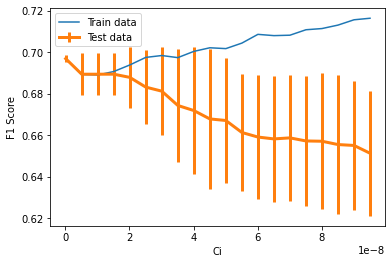

In [89]:
svm_model = []
mean_error = []
std_error = []
f1_train = []
Ci_range = np.arange(0.0000000001, 0.0000001, 0.000000005)
print(Ci_range)

for index, Ci in enumerate(Ci_range):    
    # 5 fold cross validation
    svm_model.append( LinearSVC(C=Ci, dual=False) )
    scores = cross_validate(svm_model[index], Xtrain, ytrain, cv=5, scoring='f1',return_train_score=True)
    test_score = scores['test_score']
    train_score = scores['train_score']
    mean_error.append(np.array(test_score).mean())
    std_error.append(np.array(test_score).std())
    f1_train.append(np.array(train_score).mean())


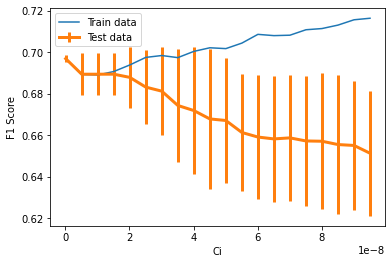

In [106]:
plt.plot(Ci_range, f1_train)    
plt.errorbar(Ci_range,mean_error,yerr=std_error,linewidth=3)
plt.legend(['Train data','Test data'])
plt.xlabel('Ci')
plt.ylabel('F1 Score')
plt.savefig(os.path.join(FIGURE_DIR,"svm_cv_ci"))
plt.show()

In [108]:
# read
with open(SVM_FILE, 'rb') as f:
    model = pickle.load(f)

In [109]:
FIXED_C = 0.0000000101

model = LinearSVC(C=FIXED_C, dual=False, max_iter=10000)
model.fit(Xtrain,ytrain)

LinearSVC(C=1.01e-08, dual=False, max_iter=10000)

In [110]:
ypred = model.predict(Xtest)
print(classification_report(ytest,ypred))
print(confusion_matrix(ytest,ypred))

              precision    recall  f1-score   support

        -1.0       0.80      0.10      0.18       118
         1.0       0.60      0.98      0.74       162

    accuracy                           0.61       280
   macro avg       0.70      0.54      0.46       280
weighted avg       0.68      0.61      0.51       280

[[ 12 106]
 [  3 159]]


In [111]:
# write
with open(SVM_FILE, 'wb') as fout:
    pickle.dump(model, fout)

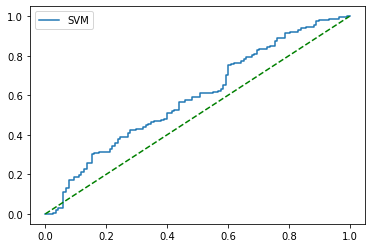

In [112]:
fpr_svm, tpr_svm, _ = roc_curve(ytest, model.decision_function(Xtest))
plt.plot(fpr_svm,tpr_svm)
plt.plot([0,1],[0,1], color='green', linestyle='--')
plt.legend(['SVM'])
plt.savefig(os.path.join(FIGURE_DIR, "roc_svm"),bbox_inches='tight')
plt.show()

In [113]:
auc_svm = roc_auc_score(ytest, model.decision_function(Xtest))
print('svm AUC:',auc_svm)

svm AUC: 0.5916509730069053


In [114]:
# top 10 words with highest impact in result
ranked = np.argsort(model.coef_)[0][::-1]

for i in ranked[:10]:
    print(vectorizer.get_feature_names()[i], model.coef_[0][i])

it 7.491445421314182e-05
you 6.769202976173476e-05
on 6.234477328886416e-05
eth 5.3418313622376715e-05
your 4.220064626300588e-05
my 3.818160301570355e-05
fee 3.800354375973259e-05
do 3.7388713030142676e-05
but 3.5745145011777486e-05
have 3.504601818170855e-05


# Baselines

In [115]:
# most frequent
common_baseline_model = DummyClassifier(strategy="most_frequent")
common_baseline_model.fit(Xtrain, ytrain)
common_baseline_prediction = common_baseline_model.predict(Xtest)
print(classification_report(ytest,common_baseline_prediction))
print(confusion_matrix(ytest,common_baseline_prediction))

auc_common = roc_auc_score(ytest, common_baseline_model.predict(Xtest))
print('common AUC:',auc_common)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       118
         1.0       0.58      1.00      0.73       162

    accuracy                           0.58       280
   macro avg       0.29      0.50      0.37       280
weighted avg       0.33      0.58      0.42       280

[[  0 118]
 [  0 162]]
common AUC: 0.5


/Users/nelsonlim/.virtualenv/tcd_ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nelsonlim/.virtualenv/tcd_ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nelsonlim/.virtualenv/tcd_ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [116]:
random_baseline_model = DummyClassifier(strategy="uniform", random_state=1 )
random_baseline_model.fit(Xtrain, ytrain)
random_baseline_prediction = random_baseline_model.predict(Xtest)
print(classification_report(ytest,random_baseline_prediction))
print(confusion_matrix(ytest,random_baseline_prediction))

auc_random = roc_auc_score(ytest, random_baseline_model.predict(Xtest))
print('random AUC:',auc_random)

              precision    recall  f1-score   support

        -1.0       0.44      0.50      0.47       118
         1.0       0.60      0.54      0.56       162

    accuracy                           0.52       280
   macro avg       0.52      0.52      0.52       280
weighted avg       0.53      0.52      0.52       280

[[59 59]
 [75 87]]
random AUC: 0.5185185185185186


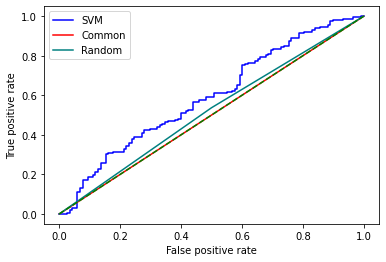

In [117]:
fpr_common, tpr_common, _ = roc_curve(ytest, common_baseline_model.predict(Xtest))
fpr_random, tpr_random, _ = roc_curve(ytest, random_baseline_model.predict(Xtest))
plt.plot(fpr_svm,tpr_svm, c='blue')
plt.plot(fpr_common,tpr_common, c='red')
plt.plot(fpr_random,tpr_random, c='teal')
plt.plot([0,1],[0,1], color='green', linestyle='--')
plt.legend(['SVM', "Common", "Random"])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.savefig(os.path.join(FIGURE_DIR, "svm_with_baselines"),bbox_inches='tight')
plt.show()